# 中能坤域-电力现货价格
候选人：韩善忠
邮箱：jackson.sz.han@gmail.com
电话：0045 50267998

## 数据说明

- date: 时间戳，年月日-时
- west_price: 西部市场价格
- east_price: 东部市场价格 （本项目不考虑）
- eater_power: 东送计划值 -- 保障的区域外的外送电量
- non-market_power: 非市场化出力 -- 不进行市场化交易的保障电量
- total_laod: 统调负荷 -- 全省用电需求量
- renewable_power: 全省新能源值 -- 风、光出力总和
- wind_power: 风电值
- solar_power: 光伏值
- bidding_space: 竞价空间 -- 火电出力竞价的需求量 （计算公式=统调负荷+东送计划-非市场化出力-全网新能源出
力）



## 任务：
1. 在表格数据中找出最能影响（西部）价格的变量特征（一个或多个）
2. 分析高价（高于700元/MWh）成因，并且涉及一个可解释的高价风险判别规则。
3. 如何根据题目1结论中的一个或多个特征做一个历史相似日分析的简单算法，用于预测电价。

## 初始化配置

In [1]:
# 环境初始化
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 数据导入
df = pd.read_csv('data.csv', header=0)

## 数据探索

In [2]:
# 简单检查数据的范围: 正好一整年的，确认其连续性
df['date']

0          2023/1/1 1:00
1          2023/1/1 2:00
2          2023/1/1 3:00
3          2023/1/1 4:00
4          2023/1/1 5:00
              ...       
8754    2023/12/31 19:00
8755    2023/12/31 20:00
8756    2023/12/31 21:00
8757    2023/12/31 22:00
8758    2023/12/31 23:00
Name: date, Length: 8759, dtype: object

In [3]:
# 日期为索引
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [4]:
# 缺失值检查
df.isnull().sum()

west_price          0
east_price          0
east_power          0
non_market_power    0
total_load          0
renewable_power     0
wind_power          0
solar_power         0
bidding_space       0
dtype: int64

In [5]:
# 数据类型检查，大数据时可酌情压缩数据格式
df.dtypes

west_price          float64
east_price          float64
east_power          float64
non_market_power    float64
total_load          float64
renewable_power     float64
wind_power          float64
solar_power         float64
bidding_space       float64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8759 entries, 2023-01-01 01:00:00 to 2023-12-31 23:00:00
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   west_price        8759 non-null   float64
 1   east_price        8759 non-null   float64
 2   east_power        8759 non-null   float64
 3   non_market_power  8759 non-null   float64
 4   total_load        8759 non-null   float64
 5   renewable_power   8759 non-null   float64
 6   wind_power        8759 non-null   float64
 7   solar_power       8759 non-null   float64
 8   bidding_space     8759 non-null   float64
dtypes: float64(9)
memory usage: 684.3 KB


In [7]:
# 数据描述性统计
df.describe()

west_price   east_price   east_power  non_market_power    total_load  \
count  8759.000000  8759.000000  8759.000000       8759.000000   8759.000000   
mean    642.152183   619.933951  2650.590505       5917.958949  37148.844700   
std     476.650407   509.406969   904.219070        648.169884   2108.828683   
min       0.000000    -0.040000     0.000000       4077.970000  33005.100000   
25%     338.420000   302.815000  2100.000000       5459.105000  35452.215000   
50%     462.920000   422.010000  2493.000000       5861.540000  36857.850000   
75%     916.205000   941.340000  3300.000000       6314.050000  38613.625000   
max    1990.580000  1966.990000  4200.010000       8406.720000  44349.530000   

       renewable_power    wind_power  solar_power  bidding_space  
count      8759.000000   8759.000000  8759.000000    8759.000000  
mean      10431.399216   8033.649455  2397.750928   23450.077108  
std        5287.225892   4400.734083  3091.807344    5480.123168  
min         809.530000    687.810000     0.000000    5491.500000  
25%        6263.935000   4437.050000     1.410000   19842.685000  
50%        9943.150000   7375.630000   219.860000   24026.370000  
75%       13955.525000  11245.015000  5094.070000   27585.705000  
max       28188.570000  20354.000000  9691.330000   39362.400000

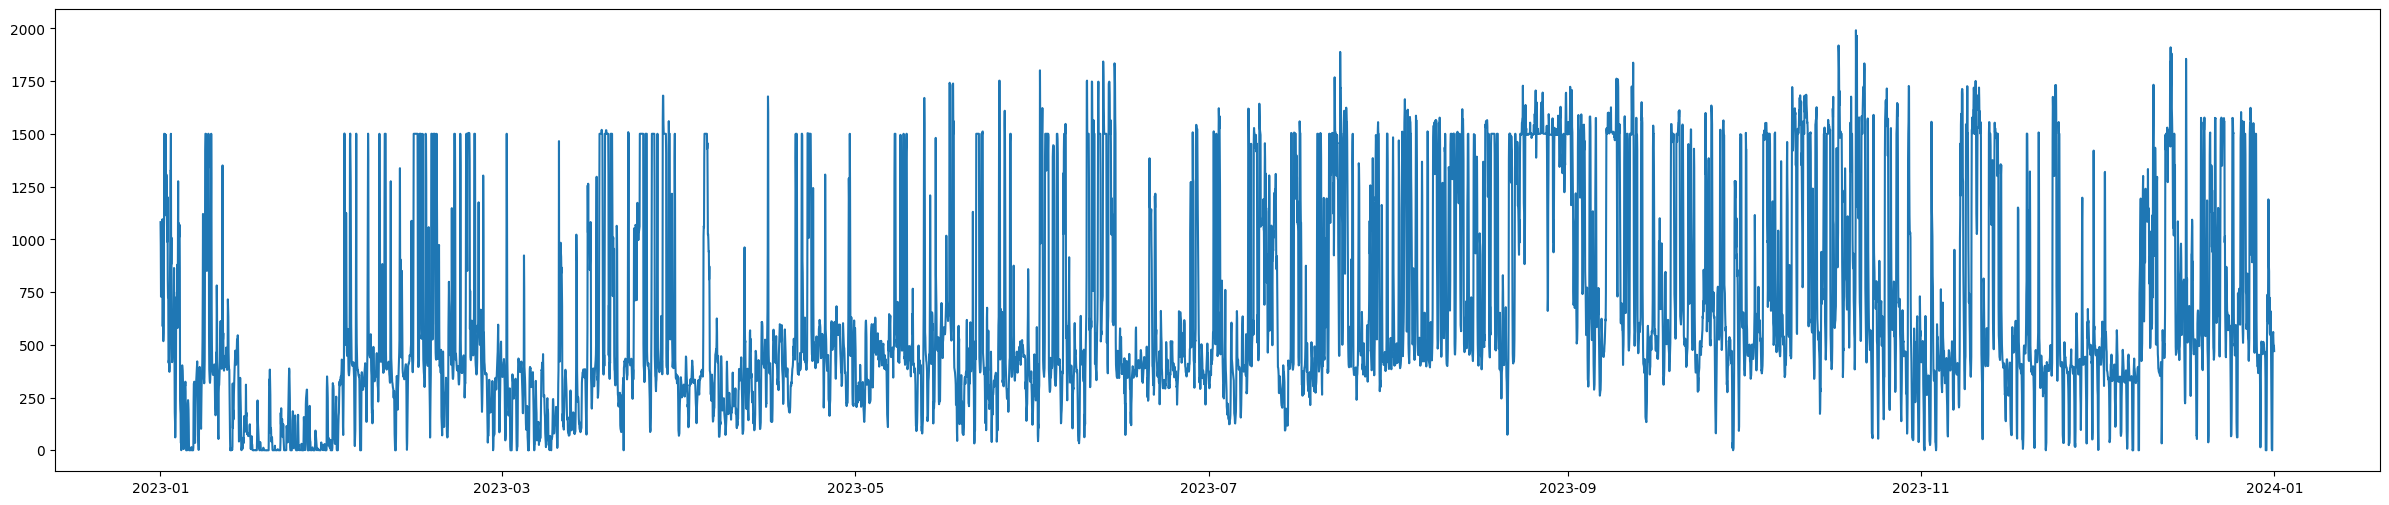

In [8]:
# 西部价格趋势图
plt.figure(figsize=(30, 6))
plt.plot(df['west_price'], label='West Price')

## 数据分析

### 问题1：相关性分析--最能影响西部电价的变量特征

In [9]:
# 特征相关性分析：使用皮尔逊相关系数对特征量进行相关性排序
# 这里没有考虑众多时间特征量 （时，日，周，月），只考虑了表格中涉及的其他变量特征,并排除了东部地区的价格
corr_features =['west_price', 'east_power', 'non_market_power', 'total_load', 'renewable_power', 'wind_power', 'solar_power', 'bidding_space']
correlation_m = df[corr_features].corr()
correlation_m

west_price  east_power  non_market_power  total_load  \
west_price          1.000000   -0.059865          0.025884    0.302506   
east_power         -0.059865    1.000000          0.113574    0.212430   
non_market_power    0.025884    0.113574          1.000000    0.529093   
total_load          0.302506    0.212430          0.529093    1.000000   
renewable_power    -0.687839    0.238692          0.104098    0.056939   
wind_power         -0.606159    0.062905          0.208436    0.045741   
solar_power        -0.313478    0.318645         -0.118662    0.032264   
bidding_space       0.767096    0.003023          0.003631    0.302351   

                  renewable_power  wind_power  solar_power  bidding_space  
west_price              -0.687839   -0.606159    -0.313478       0.767096  
east_power               0.238692    0.062905     0.318645       0.003023  
non_market_power         0.104098    0.208436    -0.118662       0.003631  
total_load               0.056939    0.045741     0.032264       0.302351  
renewable_power          1.000000    0.811468     0.555071      -0.915818  
wind_power               0.811468    1.000000    -0.035681      -0.779577  
solar_power              0.555071   -0.035681     1.000000      -0.456505  
bidding_space           -0.915818   -0.779577    -0.456505       1.000000

In [10]:
# 相关性排序
print(correlation_m['west_price'].abs().sort_values(ascending=False))

west_price          1.000000
bidding_space       0.767096
renewable_power     0.687839
wind_power          0.606159
solar_power         0.313478
total_load          0.302506
east_power          0.059865
non_market_power    0.025884
Name: west_price, dtype: float64


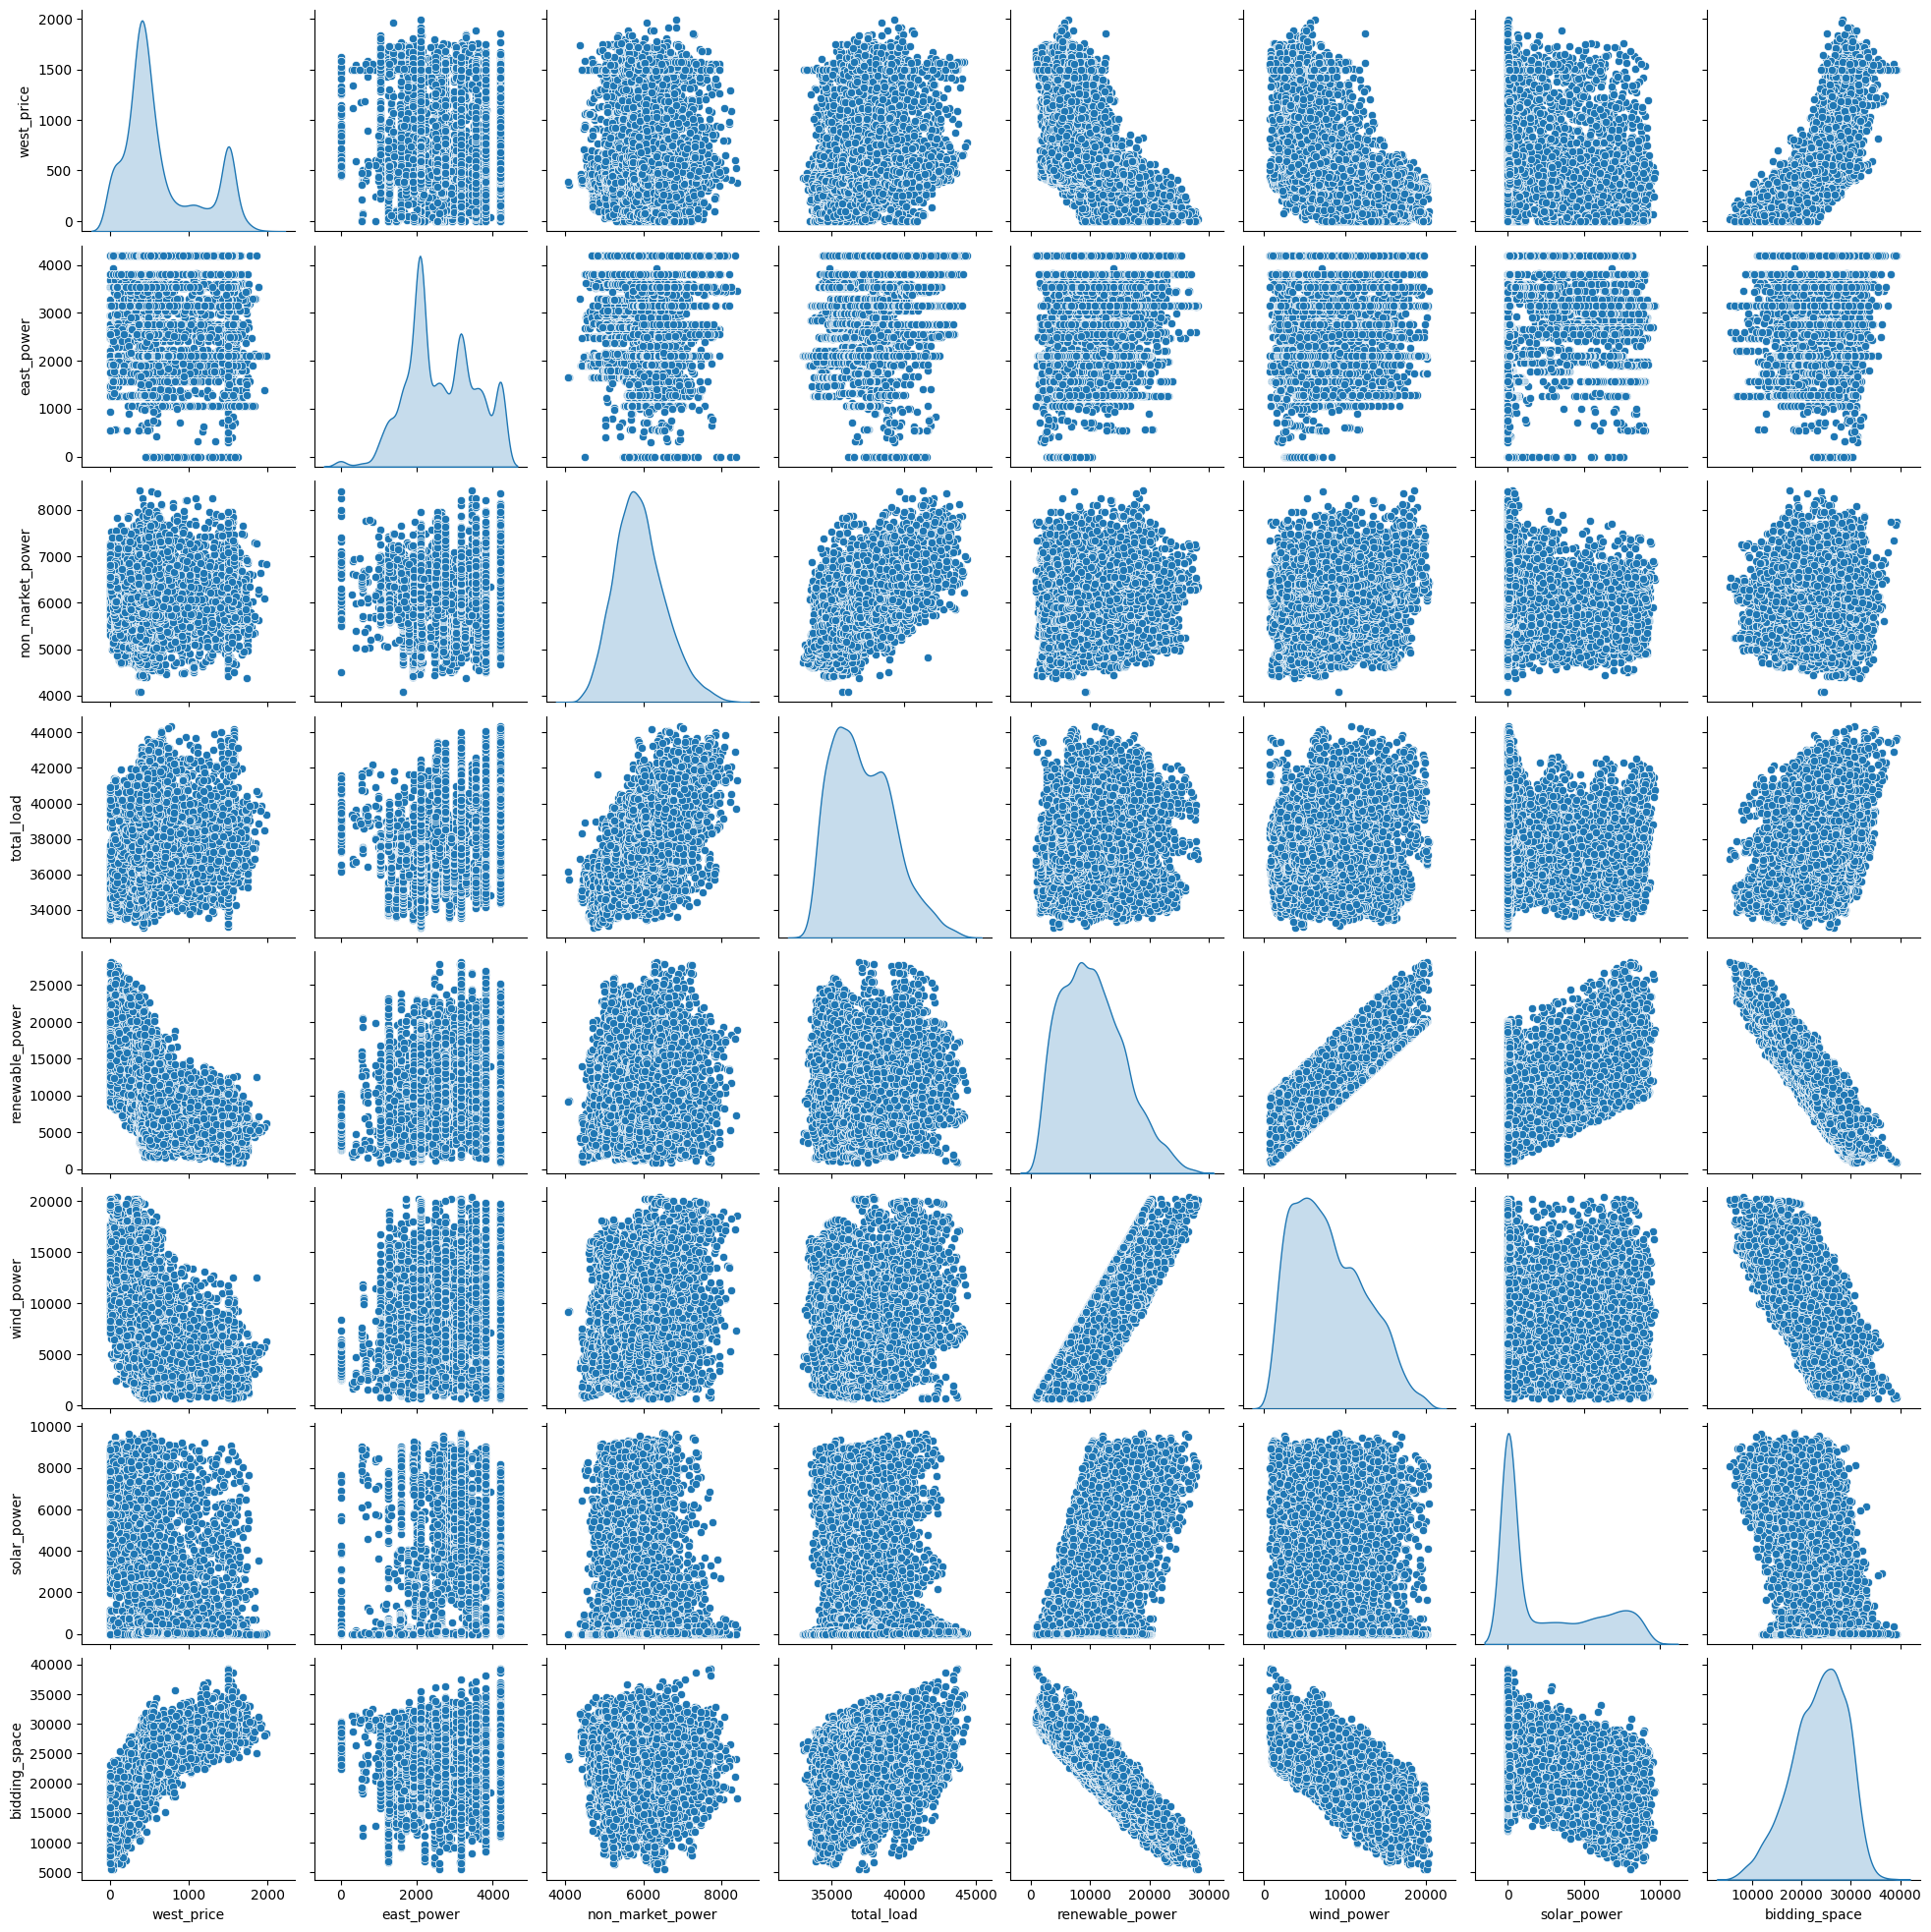

In [11]:
# 可视化相关性矩阵
sns.pairplot(df[corr_features], diag_kind='kde', markers='o')

### 问题1 结论：

竞价空间 （bidding_space）与西部电价最相关。其次是新能源总和（renewable_power）, 风电值 （wind_power。

### 问题2： 分析高价成因

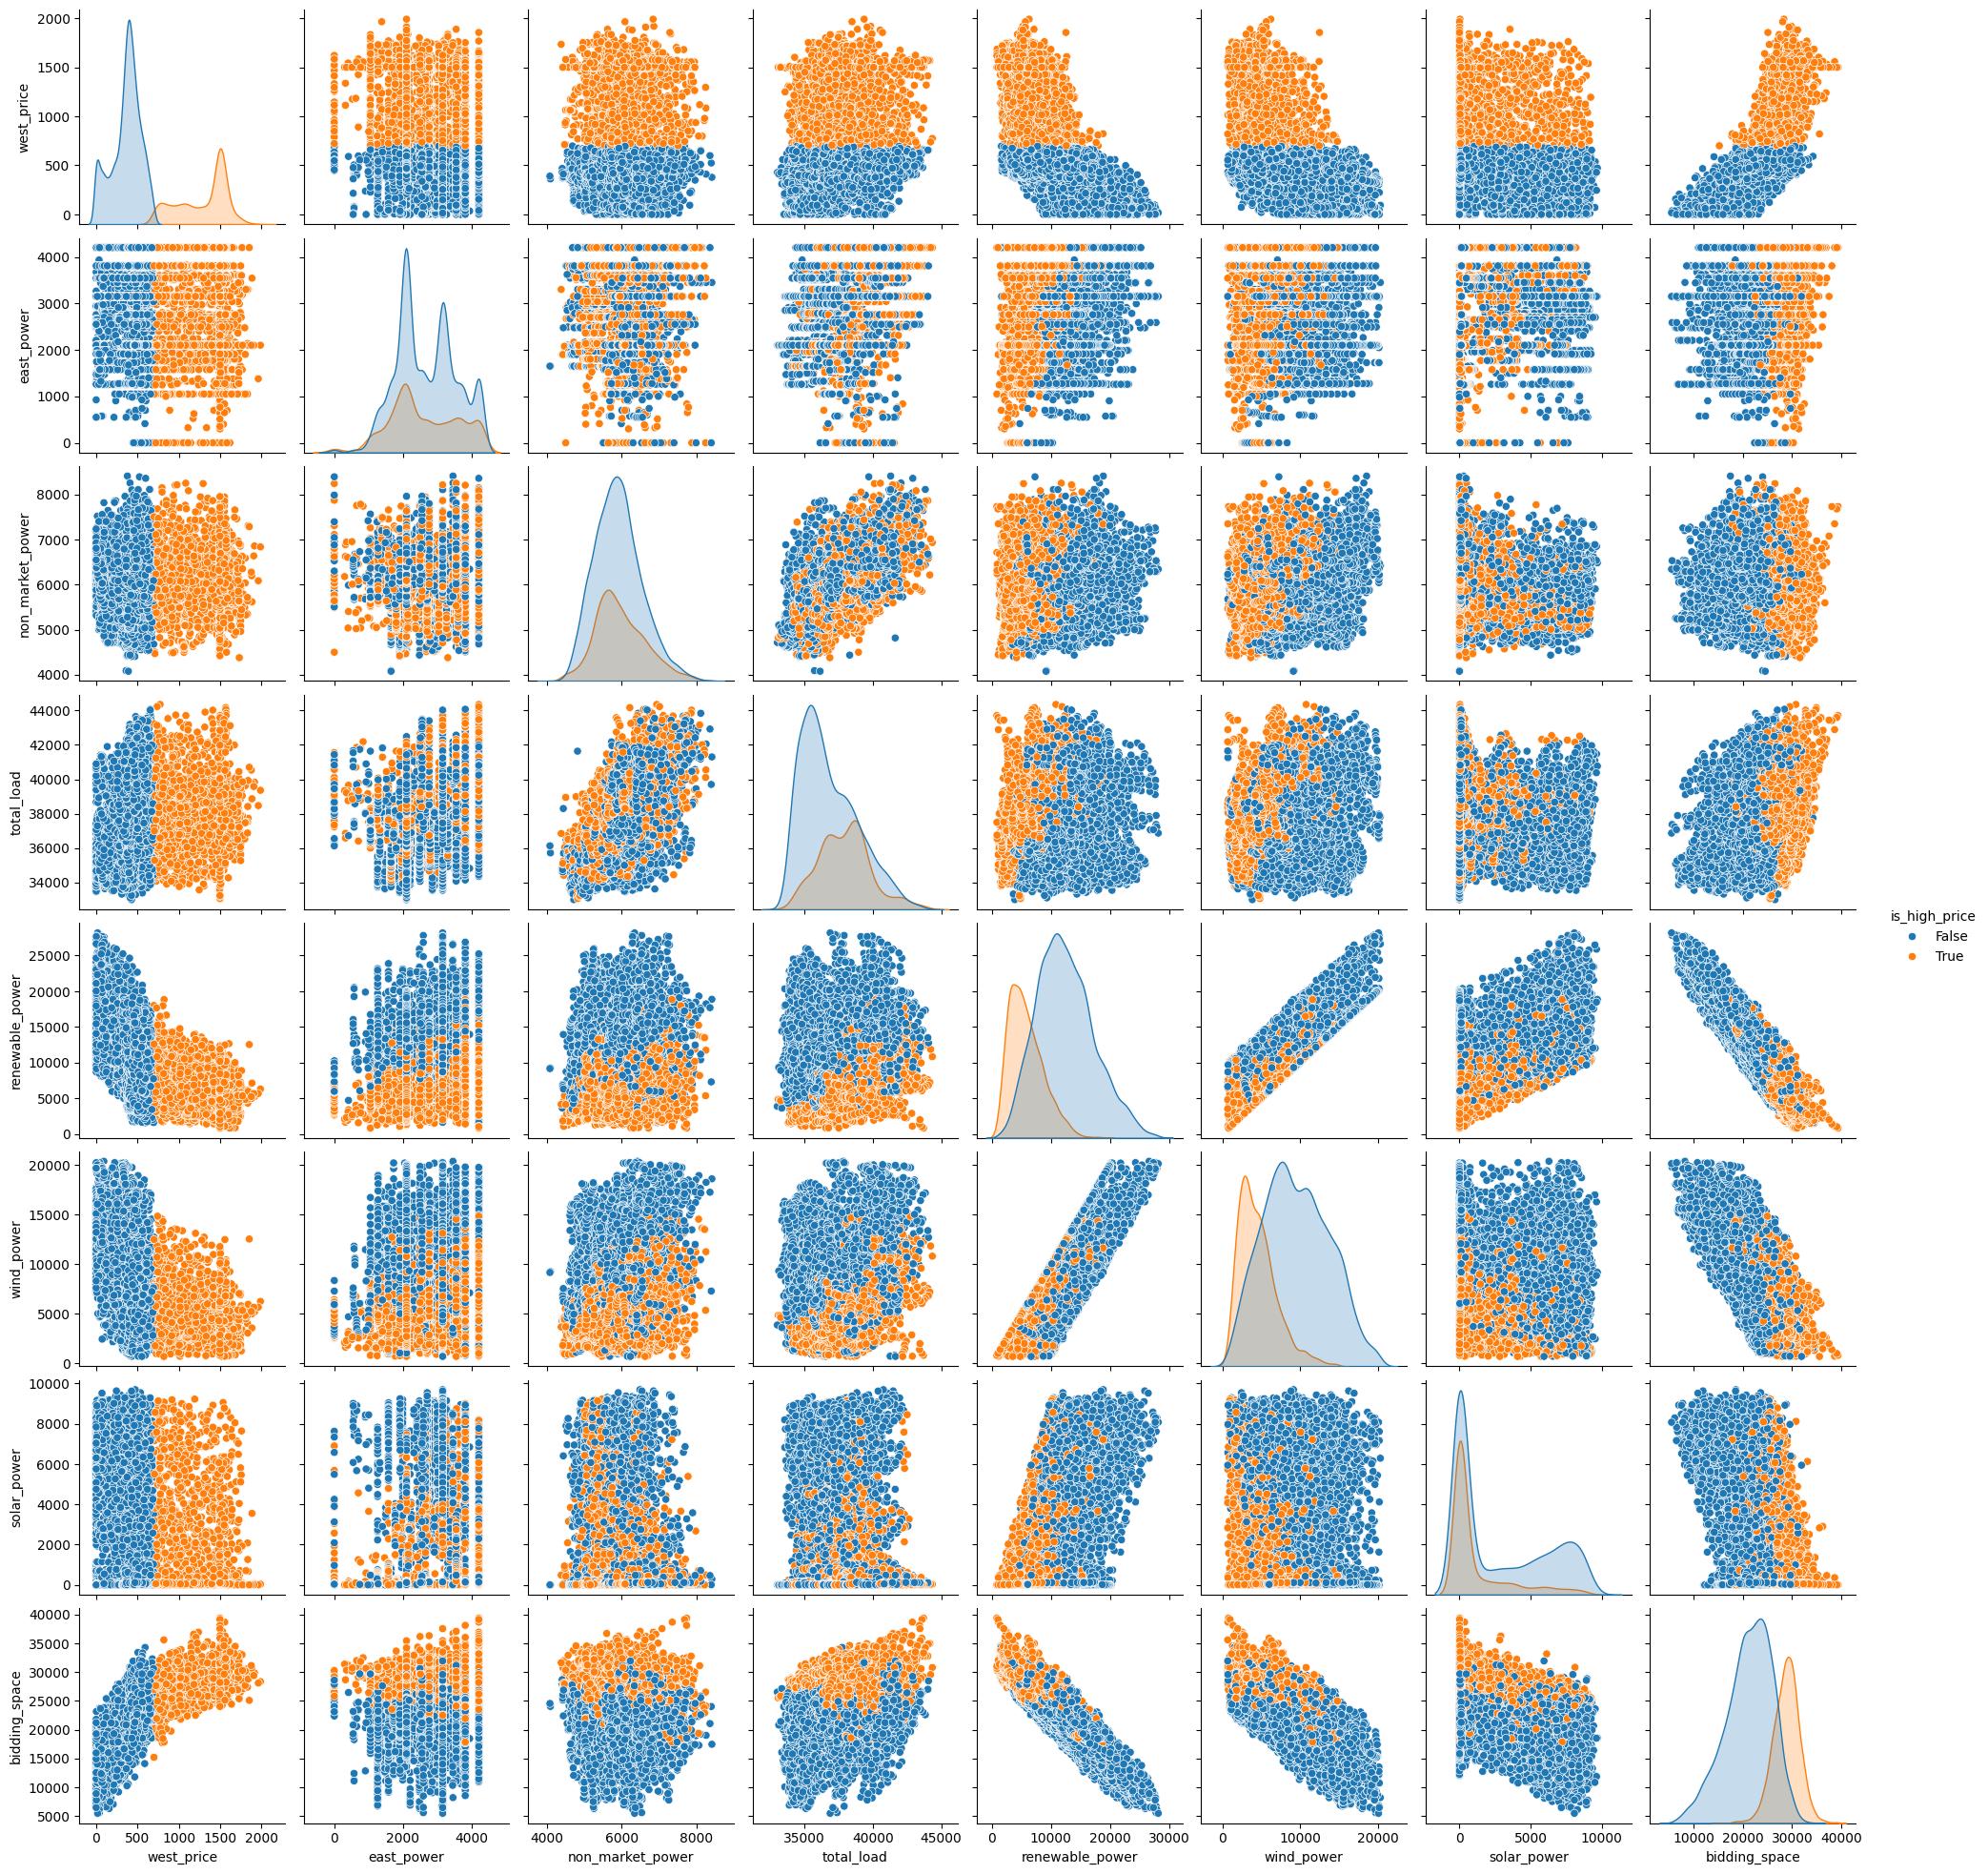

In [12]:
# 对西部电价进行二分类处理
# 这里的二分类是指：西部电价是否高于700元/兆瓦时
df_new = df[corr_features].copy()
df_new['is_high_price'] = df_new['west_price'] > 700
sns.pairplot(df_new, diag_kind='kde', markers='o', hue='is_high_price')

通过上图，我们重点关注竞价空间和新能源总和的KDE, 为了更清晰的找到分割点，我们把他们单独拿出来展示：

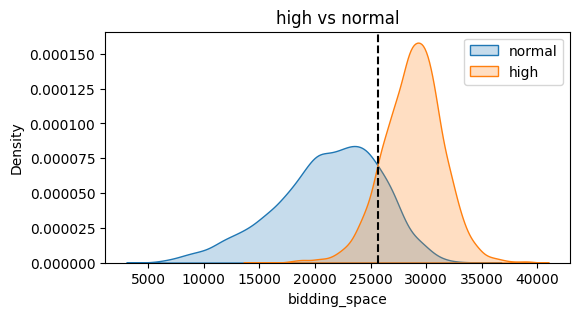

In [13]:
# 正常价格与高价格下对应的竞价空间KDE对比
plt.figure(figsize=(6,3))
sns.kdeplot(df_new.loc[df_new.is_high_price==0, 'bidding_space'], label='normal', fill=True)
sns.kdeplot(df_new.loc[df_new.is_high_price==1, 'bidding_space'], label='high',   fill=True)
plt.axvline(x=25700, color='k', linestyle='--')  # 这里我们使用一个估计值
plt.legend()
plt.title('high vs normal')
plt.show()

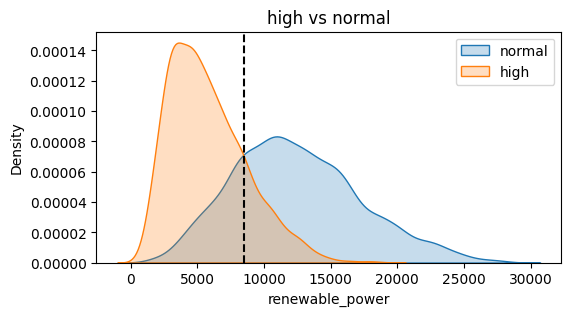

In [14]:
# 正常价格与高价格下对应的新能源KDE对比
plt.figure(figsize=(6,3))
sns.kdeplot(df_new.loc[df_new.is_high_price==0, 'renewable_power'], label='normal', fill=True)
sns.kdeplot(df_new.loc[df_new.is_high_price==1, 'renewable_power'], label='high',   fill=True)
plt.axvline(x=8500, color='k', linestyle='--')  # 这里我们使用一个估计值
plt.legend()
plt.title('high vs normal')
plt.show()

### 问题 2： 结论




成因：

由于西部电价与竞价空间（火电需求量）呈正相关，与新能源总量呈负相关。 当火电需求量大、新能源出力少的时候最容易出现高价情况。

高价风险判别规则：

在保障最佳分类分割的情况下，通过确认KDE交叉点我们可以得到高价风险判别规则：
当 (bidding_space > 25700) & (renewable_power <8500)时，容易产生高价

补充说明：

考虑进时间因素的话， 不同的时间段，价格上肯定也会有明显的分层。

### 问题 3： 历史相似日分析算法

In [15]:
# 历史相似日分析预测电价: 对任意一个时间点，寻找其K个历史相似日，取其未来24个小时的各个时间点的平均价来初步预测未来的电价

# 1. 构造滑动窗口样本： 过去24小时的竞价空间作为特征，未来24小时的西部电价作为目标
window = 24
X, Y = [], []
for i in range(window, len(df) - window):
    X.append(df['bidding_space'].values[i - window:i])
    Y.append(df['west_price'].values[i: i + window])

# 将列表转换为 NumPy 数组，方便进行数值计算
X = np.array(X)
Y = np.array(Y)

# 2. 划分训练、预测集 （0.8/0.2）
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

# 3. 标准化特征，尤其考虑多个不同尺度的特征量时，尤为重要
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)   

# 4. 使用 KNN 寻找相似日，可根据表现调整 K 值
k = 5
knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
knn.fit(X_train_scaled)

# 5. 定义预测函数，对K个相似日的西部电价进行平均来估计下一个24h电价
def predict_price(x_scaled):
    dists__, idxs = knn.kneighbors([x_scaled])
    return Y_train[idxs[0]].mean(axis=0)

# 6. 对测试集进行预测
Y_pred = np.array([predict_price(x) for x in X_test_scaled])

# 7. 评估： 计算24h序列的平均 MAW 和 RMSE
mae = mean_absolute_error(Y_test.flatten(), Y_pred.flatten())
mse = mean_squared_error(Y_test.flatten(), Y_pred.flatten())
rmse = np.sqrt(mse)

# 打印评价结果
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 320.36
Root Mean Squared Error: 434.60


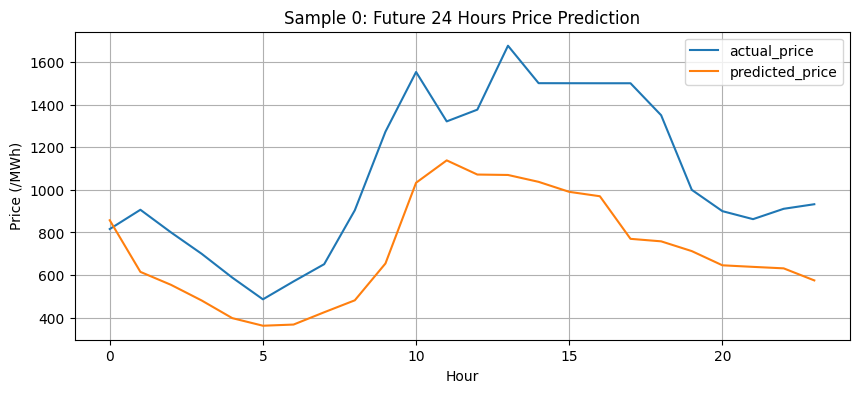

In [16]:
# 8. 可视化预测结果
plt.figure(figsize=(10, 4))
plt.plot(Y_test[0], label='actual_price')
plt.plot(Y_pred[0], label='predicted_price')
plt.legend()
plt.title('Sample 0: Future 24 Hours Price Prediction')
plt.xlabel('Hour')
plt.ylabel('Price (/MWh)')
plt.grid(True)
plt.show()